<a href="https://colab.research.google.com/github/kotdavid/Market-Intelligence-Analysis/blob/main/FDS_Lab1_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###  Chapter 8: Linear Unsupervised Learning

This notebook contains interactive content from an early draft of the university textbook <a href="https://github.com/neonwatty/machine-learning-refined/tree/main">
Machine Learning Refined (2nd edition) </a>.

The final draft significantly expands on this content and is available for <a href="https://github.com/neonwatty/machine-learning-refined/tree/main/chapter_pdfs"> download as a PDF here</a>.

## Principal Component Analysis (PCA)

The most fundamental unsupervised learning method, known as Principal Component Analysis or PCA for short, follows directly from our discussion in the previous section regarding fixed spanning set representations with one crucial caveat: instead of just learning the proper weights to best represent input data over a given fixed spanning set we learn a proper spanning set as well.

### Helper functions + Datasets

In [ ]:
# install github clone - allows for easy cloning of subdirectories
!pip install github-clone
from pathlib import Path

# clone datasets
if not Path('chapter_8_datasets').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_datasets
else:
    print('chapter_8_datasets already cloned!')

# clone library subdirectory
if not Path('chapter_8_library').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_library
else:
    print('chapter_8_library already cloned!')

# clone images
if not Path('chapter_8_images').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_images
else:
    print('chapter_8_images already cloned!')

# clone videos
if not Path('chapter_8_videos').is_dir():
    !ghclone https://github.com/neonwatty/machine-learning-refined-notes-assets/tree/main/notes/8_Linear_unsupervised_learning/chapter_8_videos
else:
    print('chapter_8_videos already cloned!')

## run universally whether in collab or local ##
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_8_library')
sys.path.append('./chapter_8_images')
sys.path.append('./chapter_8_datasets')

# import section helper
import section_8_3_helpers

# dataset paths
dataset_path_1 = 'chapter_8_datasets/2d_span_data.csv'
dataset_path_2 = 'chapter_8_datasets/3d_span_data.csv'

# image paths
image_path_1 = "chapter_8_images/pca_classic.png"
image_path_2 = "chapter_8_images/Fig_9_7.png"

# standard imports
import matplotlib.pyplot as plt
from IPython.display import Image
import autograd.numpy as np
from matplotlib import gridspec

## this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
#%matplotlib inline
#from matplotlib import rcParams
#rcParams['figure.autolayout'] = True

#%load_ext autoreload
#%autoreload 2

chapter_8_datasets already cloned!
chapter_8_library already cloned!
chapter_8_images already cloned!
chapter_8_videos already cloned!


In [ ]:
# These are only for visualization purposes. Made for the FDS lab.

def plot_datasets_side_by_side(datasets, titles, figsize=(12, 5)):
    """
    Plot 2D datasets side by side.
    """
    fig, axes = plt.subplots(1, len(datasets), figsize=figsize)

    if len(datasets) == 1:
        axes = [axes]

    for ax, data, title in zip(axes, datasets, titles):
        # Main scatter plot:
        ax.scatter(data[0, :], data[1, :], c="black", alpha=0.7)
        ax.set_title(title)
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")

        # Add grid:
        ax.grid(True, linestyle="--", alpha=0.6)

        # Cartesian axes
        ax.axhline(0, color="gray", linewidth=1)
        ax.axvline(0, color="gray", linewidth=1)

        # Compute mean and variance:
        mean_x, mean_y = np.mean(data, axis=1)
        var_x, var_y = np.var(data, axis=1)

        # Add stats text:
        stats_text = f"Mean = ({mean_x:.2f}, {mean_y:.2f})\nVariance = ({var_x:.2f}, {var_y:.2f})\nTotal Var. = {round(var_x + var_y, 2)}"
        ax.text(0.05, 0.15, stats_text, transform=ax.transAxes,
                fontsize=9, verticalalignment='top',
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="gray"))


    plt.tight_layout()
    plt.show()



def plot_with_pcs(X, D, V, scale=2.0):
    """
    Plot a 2D mean-centered dataset with its principal components.

    Parameters:
    ----------
    X : array of shape (2, N)
        Mean-centered dataset.
    D : array
        Eigenvalues (sorted in descending order).
    V : array
        Eigenvectors (columns are PCs, sorted in descending order).
    scale : float
        Factor to scale arrow lengths for visibility.
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(X[0, :], X[1, :], c="black", alpha=0.7, label="Data")

    # Cartesian axes
    plt.axhline(0, color="gray", linewidth=1)
    plt.axvline(0, color="gray", linewidth=1)

    # plot principal components as arrows
    origin = np.array([[0, 0]])
    for i in range(V.shape[1]):
        vec = V[:, i] * np.sqrt(D[i]) * scale
        plt.quiver(*origin.T, vec[0], vec[1], angles='xy', scale_units='xy',
                   scale=1, color=['red','blue'][i], label=f"PC{i+1}")

    plt.title("Mean-centered data with principal components")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.axis("equal")
    plt.show()

## Part 1: Principal Component Analysis From Scratch

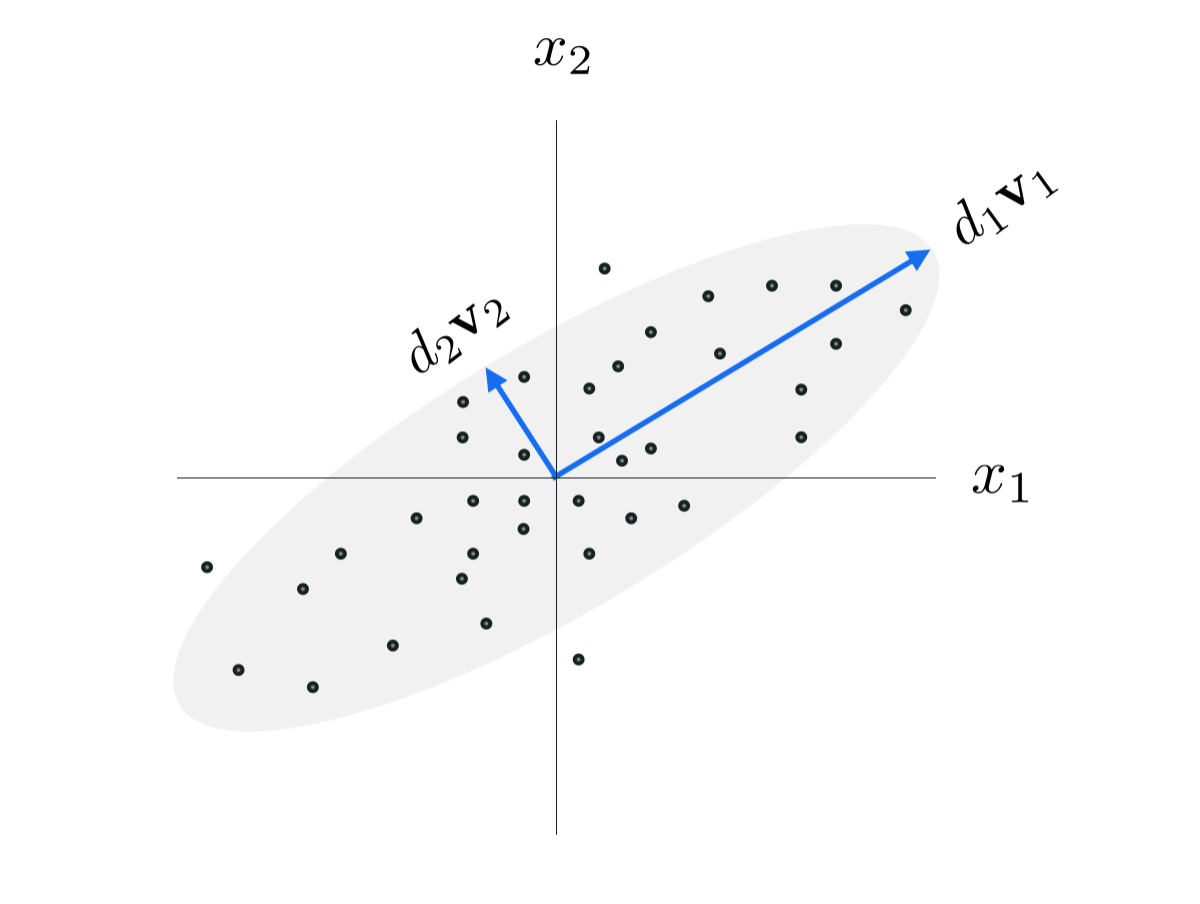

In [ ]:
Image(image_path_1)

Let $X$ be the $N \times P$ data matrix, consisting of our $P$ mean-centered input points stacked column-wise:

\begin{equation}
\mathbf{X} =
\begin{bmatrix}
\vert  \,\,\,\,\,\,\, \vert  \,\,\,\,\,  \cdots  \,\,\,\,\, \vert \\
\,\, \mathbf{x}_1 \,\,\, \mathbf{x}_2 \,\,\, \cdots \,\,\, \mathbf{x}_P \\
\vert  \,\,\,\,\,\,\, \vert  \,\,\,\,\,  \cdots  \,\,\,\,\, \vert
\end{bmatrix}
\end{equation}

To perform the PCA, we start by computing the *covariance* matrix of X:

\begin{equation}
\text{covariance matrix of } \, \mathbf{X}: = \, \frac{1}{N}\mathbf{X}^{\,} \mathbf{X}^T
\end{equation}

And then  we apply the eigenvector/value decomposition of this covariance matrix:

\begin{equation}
\frac{1}{N}\mathbf{X}^{\,} \mathbf{X}^T = \mathbf{V}^{\,}\mathbf{D}^{\,}\mathbf{V}^T
\end{equation}

These are referred to in the jargon of machine learning as the *principal components* of the data.  Moreover, the variance in each (principal component) direction is given precisely by the corresponding eigenvalue in $\mathbf{D}$.

In [ ]:
def center(X):
    '''
    A function for normalizing each feaure dimension of an input array (mean-centering)

    '''
    X_means = np.mean(X,axis=1)[:,np.newaxis]
    X_normalized = X - X_means

    return X_normalized

def compute_pcs(X, lam):
    '''
    Compute principal components (PCs) of input data matrix.
    Returns eigenvalues and eigenvectors sorted *in descending order*.
    '''
    N = float(X.shape[1])
    Cov = 1/N * np.dot(X, X.T) + lam * np.eye(X.shape[0])

    # eigen decomposition
    D, V = np.linalg.eigh(Cov)

    # sort eigenvalues (and eigenvectors) in descending order
    idx = np.argsort(D)[::-1]
    D = D[idx]
    V = V[:, idx]

    return D, V

def pca_transform_data(X,**kwargs):
    '''
    A function for producing the full PCA transformation on an input dataset X.
    '''
    # user-determined number of principal components to keep, and regularizer penalty param
    num_components = X.shape[0]
    if 'num_components' in kwargs:
        num_components = kwargs['num_components']
    lam = 10**(-7)
    if 'lam' in kwargs:
        lam = kwargs['lam']

    # compute principal components
    D,V = compute_pcs(X,lam)
    V = V[:,-num_components:]
    D = D[-num_components:]

    # compute transformed data for PC space: V^T X
    W = np.dot(V.T,X)
    return W,V

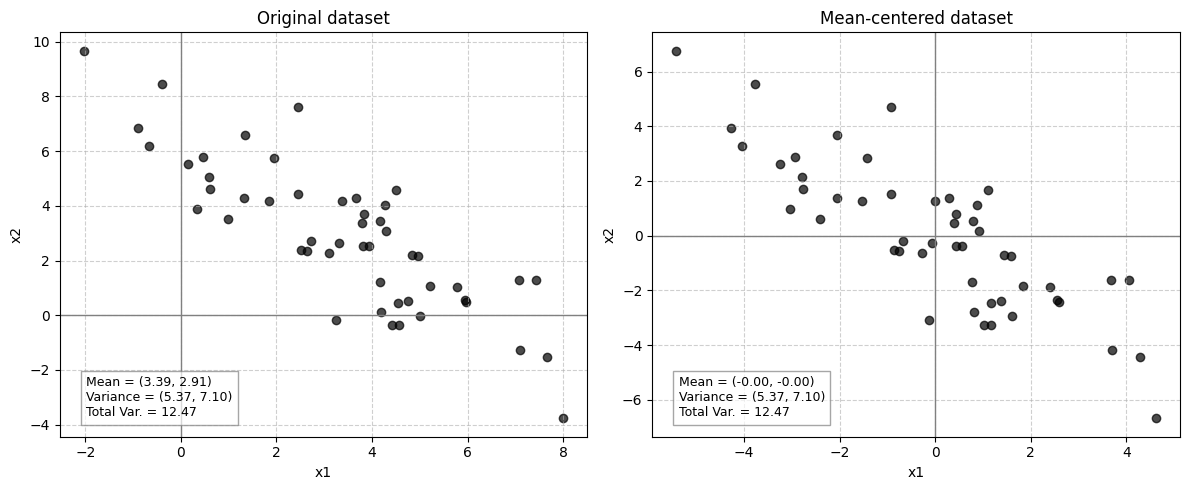

In [ ]:
# With our dataset (using helper functions):
X_original = np.loadtxt(dataset_path_1, delimiter=',')
X_centered = center(X_original)

plot_datasets_side_by_side(
    [X_original, X_centered],
    ["Original dataset", "Mean-centered dataset"]
)


Eigenvalues:
[11.47205847  0.99633829]

Eigenvectors:
[[-0.64634856 -0.7630423 ]
 [ 0.7630423  -0.64634856]]

-----------------------------------------------------------------



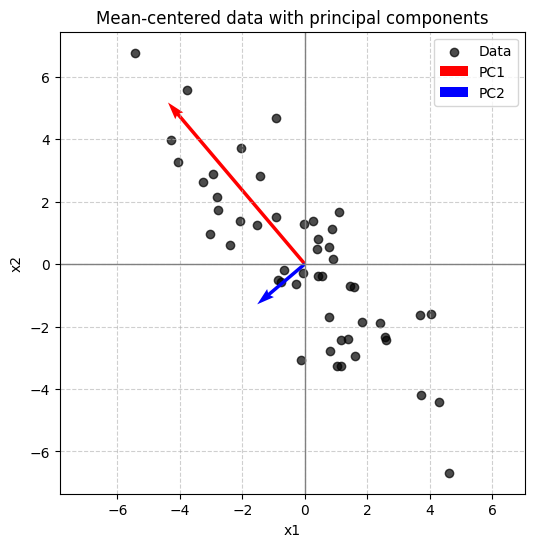

In [ ]:
# Compute eigenvalues and eigenvectors
D, V = compute_pcs(X_centered, lam=1e-7)

# Print eigenvalues...
print("\nEigenvalues:")
print(D)

# ... and eigenvectors
print("\nEigenvectors:")
print(V)
print(f"\n{"-"*65}\n")

###########################################

plot_with_pcs(X_centered, D, V)


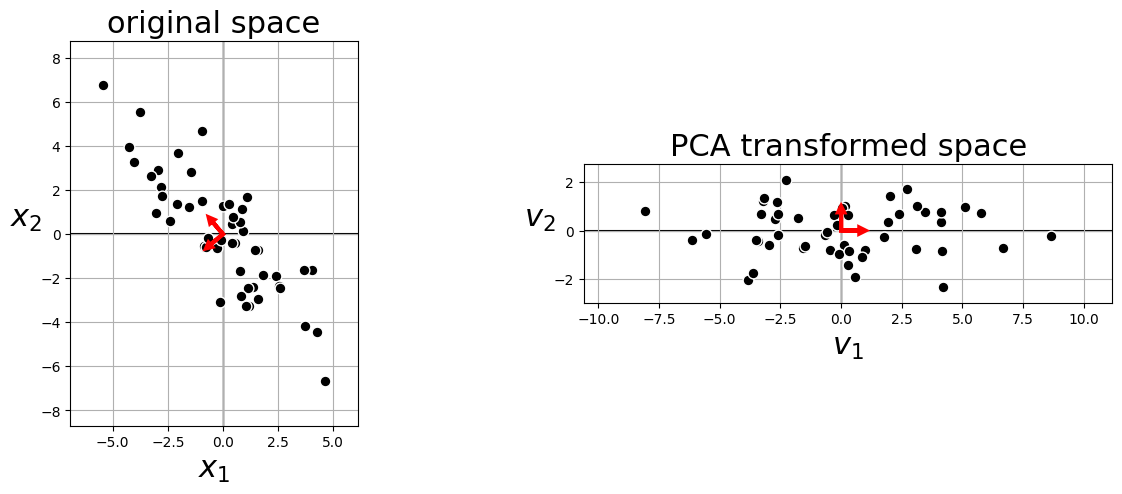

In [ ]:
# Load in dataset to perform PCA on, and mean-center
X_original = np.loadtxt(dataset_path_1,delimiter=',')

# Mean-center the data
X = center(X_original)

# Compute the full PCA transformation of dataset
W,V = pca_transform_data(X)

# Plot data in original and pca-transformed spaces
section_8_3_helpers.pca_visualizer(X,W,V)

# Part 2: PCA Can Win Your Fantasy Football

In [ ]:
!pip install github-clone
from pathlib import Path

# clone your dataset repo
if not Path('FDS-25-26').is_dir():
    !ghclone https://github.com/simonefacchiano/FDS-25-26
else:
    print('FDS-25-26 already cloned!')

# dataset path (file dentro Lab01)
dataset_path = 'FDS-25-26/Lab01/fantasy_football.xlsx'

FDS-25-26 already cloned!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
import plotly.express as px
import plotly.graph_objects as go

df = pd.read_excel(dataset_path)
df.head()

,Player,Position,Matches_24_25,FV_24_25,Goals_24_25,xG_24_25,Shots_24_25,Assists_24_25,xA_24_25,Yellows_24_25
0,Retegui,A,36,8.67,25,23.058811,104,7,5.460668,2
1,Kean,A,32,8.08,19,21.887754,105,2,2.322036,6
2,Lookman,A,31,7.94,15,13.808705,82,4,8.887300,4
3,Orsolini,C,29,8.19,15,10.357791,75,4,4.652595,2
4,Thuram,A,32,7.75,14,12.123272,65,4,4.545050,1


In [ ]:
# Consistent color map across plots
roles = df["Position"].astype(str).unique().tolist()
palette = px.colors.qualitative.Plotly
COLORS_BY_ROLE_HEX = {role: palette[i % len(palette)] for i, role in enumerate(roles)}

fig = px.scatter_3d(
    df,
    x="Shots_24_25",
    y="Goals_24_25",
    z="Assists_24_25",
    color="Position",
    color_discrete_map=COLORS_BY_ROLE_HEX,
    hover_name="Player",
    opacity=0.75,
    title="3D: Shots vs Goals vs Assists (pre–dimensionality reduction)"
)

fig.update_layout(
    scene=dict(
        xaxis=dict(title="Sots (24/25)", range=[0, 90]),
        yaxis=dict(title="Goals (24/25)", range=[0, max(1, df["Goals_24_25"].max() + 1)]),
        zaxis=dict(title="Assists (24/25)", range=[0, max(1, df["Assists_24_25"].max() + 1)])
    )
)
fig.update_traces(marker=dict(size=5))
fig.show()

In [ ]:
# --- Build numeric matrix X and aligned labels (exclude Player & Position) ---
# Keep rows without NaN and convert features to numeric safely
df_sub = df.dropna().copy()

feat_cols = [c for c in df_sub.columns if c not in ["Player", "Position"]]
num_block = df_sub[feat_cols].apply(pd.to_numeric, errors="coerce")

# Drop rows that became NaN after coercion (e.g., stray strings)
mask = num_block.notna().all(axis=1)
X = num_block.loc[mask].to_numpy()                 # (n_samples, n_features)
players = df_sub.loc[mask, "Player"].to_numpy()    # align names
position = df_sub.loc[mask, "Position"].to_numpy()    # align positions

In [ ]:
# --- Standardize + PCA(2D) + scatter ---
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd
import numpy as np

scaler = StandardScaler(with_mean=True, with_std=True)
X_std = scaler.fit_transform(X)

pca = PCA(n_components=2, svd_solver="auto", random_state=0)
Z = pca.fit_transform(X_std)
evr = pca.explained_variance_ratio_

print("Explained variance ratio:", np.round(evr, 3))
print("Total explained (PC1+PC2):", np.round(evr.sum(), 3))

Explained variance ratio: [0.597 0.162]
Total explained (PC1+PC2): 0.759


In [ ]:
df_pca = pd.DataFrame({
    "PC1": Z[:, 0],
    "PC2": Z[:, 1],
    "Position": position,
    "Player": players,
})

fig = px.scatter(
    df_pca,
    x="PC1", y="PC2",
    color="Position",
    color_discrete_map=COLORS_BY_ROLE_HEX,  # stessa mappa colori della cella 3D
    hover_name="Player",
    hover_data={"Position": True, "PC1": ':.2f', "PC2": ':.2f'},
    labels={"Position": "Position"},
    title=f"PCA projection | var: PC1={evr[0]:.2f}, PC2={evr[1]:.2f}",
)
fig.update_traces(marker=dict(size=8, opacity=0.85))
fig.update_xaxes(showgrid=True, gridcolor="lightgray", gridwidth=0.5, title_text="PC1")
fig.update_yaxes(showgrid=True, gridcolor="lightgray", gridwidth=0.5, title_text="PC2")
fig.update_layout(template="simple_white", legend_title_text="Position", height=600, width=800)
fig.show()